# Carbon System Data Analysis

---
### Purpose
The purpose of this notebook is to analyze the performance of the Sunburst Sensors, LLC. SAMI-pH (PHSEN) pH and SAMI-pCO$_{2}$ seawater measurements, and the Pro-Oceanus pCO2 sensor measurements at the Pioneer Coastal Array and Global Irminger Array. This is done on a deployment-by-deployment, site-by-site comparison with the pH measurements from discete water samples collected by Niskin Bottle casts during deployment and recovery of the instrumentation during mooring maintainence. 

---
### Datasets
There are three main sources of data sources:
* **Deployments**: These are the deployment master sheets from OOI Asset Management. They contain the deployment numbers, deployment start times and cruise, and recovery times and cruise, for all of the instrumentation deployed. 
* **PHSEN**: This is the Sunburst Sensors, LLC. SAMI-pH sensor. It is calibrated for pH values from 70-9.0 pH units for salinities from 25-40 psu. Manufacturers stated accuracy of 0.003 pH units, precision < 0.001 pH units, and long-term drift of < 0.001 pH units / 6 months. The data is downloaded from the Ocean Observatories data portal (OOINet) as netCDF files.
* **PCO2W**: This is the Sunburst Sensors, LLC. SAMI-CO<sub>2</sub> sensor. It is calibrated for pCO<sub>2</sub> concentrations from 200 - 1000 ppm. Manufacturers stated accuracy of 3 ppm, precision < 1 ppm, and long-term drift of < 1 ppm / 6 months. The data is downloaded from the Ocean Observatories data portal (OOINet) as netCDF files.
* **CTDBP**: This is the collocated SeaBird CTD with the PHSEN. The data is downloaded from the Ocean Observatories data portal (OOINet) as netCDF files. These data are needed since the PCO2W datasets do not contain either temperature (T), salinity (S), pressure (P), or density ($\rho$) data needed to compare with the discrete sampling.
* **Discrete Water Samples**: These are discrete water samples collected via Niskin Bottle casts during deployment and recovery of the moored instrumentation. The data is downloaded from OOI Alfresco website as excel files. Parameters sampled include oxygen, salinity, nutrient concentrations (phosphate, nitrate, nitrite, ammonium, silicate), chlorophyll concentrations, and the carbon system. The carbon system parameters sampled are Total Alkalinity (TA), Dissolved Inorganic Carbon (DIC), and pH. 
---
### Method
#### PCO2W Processing
Verifying the in-situ pCO<sub>2</sub> measured by the PCO2W against the pCO<sub>2</sub> calculated from the discrete water samples TA and DIC requires several preprocessing steps of the PCO2W datasets. First, the netCDF datasets are opened using ```xarray``` into an xarray ```dataset``` object and the primary dimension set to 'time'. Next, T, S, P, and $\rho$ are interpolated to the PCO2W time base using xarray ```ds.interp_like``` from the dataset from the collocated CTDBP. Next, the pCO2 is corrected for hydrostatic pressure using a correction of 15% per 1000 dbar pressure (Enns 1965, Reed et al. 2018). Then the first and last four days of PCO2W data are selected. The standard deviation of the selected pCO2 is calculated using the first-order differencing with a time-lag of one, in order to arrive at a quasi-stationary time series.

#### CTDBP Processing
The associated CTD datasets to the PCO2W are opened using ```xarray``` into an xarray ```dataset``` object and the primary dimension set to 'time'. The CTD dataset T, S, P, and $\rho$ are interpolated to the PCO2W time base and merged into the PCO2W dataset using ```ds.interp_like```. 

#### Discrete Water Samples Processing
The relevant deployment and recovery cruise data for comparison with the PCO2W dataset(s) are opened and loaded into a pandas ```DataFrame``` object. Next, the pCO<sub>2</sub> concentrations are calculated using the ```CO2SYS``` package from the associated TA and DIC concentrations. The bottle samples are then filtered by cruise, time, and depth to identify the samples associated with the deployment and recovery of the PCO2W dataset being analyzed.

In [1]:
import os, sys, gc
import json
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Import the OOI M2M tool
sys.path.append("/home/andrew/Documents/OOI-CGSN/ooinet/ooinet/")
from m2m import M2M

#### Set OOINet API access
In order access and download data from OOINet, need to have an OOINet api username and access token. Those can be found on your profile after logging in to OOINet. Your username and access token should NOT be stored in this notebook/python script (for security). It should be stored in a yaml file, kept in the same directory, named user_info.yaml.

In [4]:
# Import user info for connecting to OOINet via M2M
userinfo = yaml.load(open("../../../../QAQC_Sandbox/user_info.yaml"), Loader=yaml.FullLoader)
username = userinfo["apiname"]
token = userinfo["apikey"]

#### Connect to OOINet

In [5]:
OOINet = M2M(username, token)

---
## Discrete Bottle Data

#### Irminger Sea
First, load the bottle data from the Irminger Sea Array into a pandas dataframe. Once the data is loaded, then we'll do some datatype conversions, such as converting the Dates and Times into pandas datetime objects, as well as replacing the fill value of ```-9999999``` with NaNs. Finally, we'll drop the data from the table that doesn't have any DIC, Alkalinity, or pH data to get the relevant carbon system data we'll need for comparisons.

We'll also want to check the associated bottle and discrete sample flags. In particular, we'll want to check for ```Niskin Flag``` with a flag of ```*0000000000001000``` which indicates a leaking bottle, and the ```Discrete TA/DIC/pH Flag``` for entries of either ```*0000000000000010```, which indicates the sample analysis is not yet complete, or ```*0000000000001000``` / ```*0000000000010000``` which indicate suspicious or bad data. We'll translate these flags into the standard WOCE schema of:
* 1 = good data
* 2 = no evaluation
* 3 = questionable data
* 4 = bad data
* 9 = missing/no data

In [6]:
irminger_sea = pd.read_csv("../data/water_sampling/Irminger_Sea_water_sampling_data.csv")
irminger_sea.head()

,Cruise,Station,Target Asset,Start Latitude [degrees],Start Longitude [degrees],Start Time [UTC],Cast,Cast Flag,Bottom Depth at Start Position [m],CTD File,...,Discrete pH Replicate Flag,Calculated Alkalinity [umol/kg],Calculated DIC [umol/kg],Calculated pCO2 [uatm],Calculated pH,Calculated CO2aq [umol/kg],Calculated Bicarb [umol/kg],Calculated CO3 [umol/kg],Calculated Omega-C,Calculated Omega-A
0,AR7-01,2,Release test,51.976000,-45.759500,2016-07-06T11:29:36.000Z,2,*0000000000000100,4056,D:\Data\ar0701002.hex,...,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999
1,AR7-01,2,Release test,51.976000,-45.759500,2016-07-06T11:29:36.000Z,2,*0000000000000100,4056,D:\Data\ar0701002.hex,...,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999
2,AR7-01,2,Release test,51.976000,-45.759500,2016-07-06T11:29:36.000Z,2,*0000000000000100,4056,D:\Data\ar0701002.hex,...,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999
3,AR7-01,3,Release test,51.971167,-45.764833,2016-07-06T14:10:07.000Z,3,*0000000000000100,-9999999,D:\Data\ar0701003.hex,...,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999
4,AR7-01,4,Release test,51.971167,-45.764833,2016-07-06T17:02:22.000Z,4,*0000000000000100,-9999999,D:\Data\ar0701004.hex,...,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999


Replace -9999999 with NaNs


In [7]:
irminger_sea = irminger_sea.replace(to_replace="-9999999", value=np.nan)
irminger_sea = irminger_sea.replace(to_replace=-9999999, value=np.nan)

Convert times from strings to pandas datetime objects


In [8]:
def convert_times(x):
    if type(x) is str:
        x = x.replace(" ","")
        x = pd.to_datetime(x)
    else:
        pass
    return x

irminger_sea["Start Time [UTC]"] = irminger_sea["Start Time [UTC]"].apply(lambda x: convert_times(x))
irminger_sea["CTD Bottle Closure Time [UTC]"] = irminger_sea["CTD Bottle Closure Time [UTC]"].apply(lambda x: convert_times(x))

#### Pioneer Bottle Data
Next, repeat the process for the Irminger Sea Array bottle data with the Pioneer Array bottle data.  

In [9]:
pioneer = pd.read_csv("../data/water_sampling/pioneer_array_water_sampling_data.csv")
pioneer.head()

,Cruise,Station,Target Asset,Start Latitude [degrees],Start Longitude [degrees],Start Time [UTC],Cast,Cast Flag,Bottom Depth at Start Position [m],CTD File,...,Calculated pCO2 [uatm],Calculated pH,Calculated CO2aq [umol/kg],Calculated Bicarb [umol/kg],Calculated CO3 [umol/kg],Calculated Omega-C,Calculated Omega-A,Comments,Chlorophyll Comments,Chl Comments
0,AR4A,1,CNSM,40.1366666666667,-70.7715,2016-05-13T15:08:28.000Z,1,*0000000000000100,134,ar04a001.hex,...,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,NaN,NaN,NaN
1,AR4A,1,CNSM,40.1366666666667,-70.7715,2016-05-13T15:08:28.000Z,1,*0000000000000100,134,ar04a001.hex,...,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,Dupes,extreme phaeo:chl ratio but reasonable because...,NaN
2,AR4A,1,CNSM,40.1366666666667,-70.7715,2016-05-13T15:08:28.000Z,1,*0000000000000100,134,ar04a001.hex,...,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,NaN,NaN,NaN
3,AR4A,1,CNSM,40.1366666666667,-70.7715,2016-05-13T15:08:28.000Z,1,*0000000000000100,134,ar04a001.hex,...,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,NaN,NaN,NaN
4,AR4A,1,CNSM,40.1366666666667,-70.7715,2016-05-13T15:08:28.000Z,1,*0000000000000100,134,ar04a001.hex,...,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,Chl. Max,NaN,NaN


Replace -9999999 with NaNs


In [10]:
pioneer = pioneer.replace(to_replace="-9999999", value=np.nan)
pioneer = pioneer.replace(to_replace=-9999999, value=np.nan)

Convert times from strings to pandas datetime objects


In [11]:
pioneer["Start Time [UTC]"] = pioneer["Start Time [UTC]"].apply(lambda x: convert_times(x))
pioneer["CTD Bottle Closure Time [UTC]"] = pioneer["CTD Bottle Closure Time [UTC]"].apply(lambda x: convert_times(x))

Convert times from strings to pandas datetime objects


In [12]:
pioneer["Start Time [UTC]"] = pioneer["Start Time [UTC]"].apply(lambda x: convert_times(x))
pioneer["CTD Bottle Closure Time [UTC]"] = pioneer["CTD Bottle Closure Time [UTC]"].apply(lambda x: convert_times(x))

#### Filter data
Next, we want to filter the data based on the data flag associated with the sample. First, we should drop all of the ```NaN``` values in the Niskin column to eliminate entries without any bottle samples.

In [13]:
irminger_sea = irminger_sea.dropna(subset=["Niskin/Bottle Position"])
pioneer = pioneer.dropna(subset=["Niskin/Bottle Position"])

Now, translate the bit map flag of the file into the standard WOCE format

In [14]:
import re

class QualityFlags():
    """Primary flags for QARTOD"""
    
    GOOD = 1
    UNKNOWN = 2
    SUSPECT = 3
    BAD = 4
    MISSING = 9

FLAGS = QualityFlags

def check_fill(flag):
    """Function to check if the flag is a fill value"""
    if pd.isna(flag):
        return True
    elif str(flag) == "-9999999":
        return True
    elif "1" not in str(flag):
        return True
    else:
        return False

def parse_flag(flag):
    """Function to parse the quality flag. Returns fill or nan when appropriate."""
    locs=[]
    for match in re.finditer("1", flag[::-1], re.S):
        locs.append(match.span()[0])
    return locs
    
def interp_ctd_flag(flag):
    "Function which interprets CTD flags to standard convention"
    
    # First filter for fill 
    if check_fill(flag):
        return flag
    else:
        parsed_flag = parse_flag(flag)
        max_bit = max(parsed_flag)
        if max_bit == 1:
            return QualityFlags.MISSING
        elif max_bit == 2:
            return QualityFlags.GOOD
        elif max_bit == 3:
            return QualityFlags.SUSPECT
        elif max_bit == 4:
            return QualityFlags.BAD
        else:
            return QualityFlags.UNKNOWN
        
def interp_discrete_flag(flag):
    """Function which interprets discrete Bottle flags to standard convention."""
    
    # First filter for fill values
    if check_fill(flag):
        return flag
    else:
        parsed_flag = parse_flag(flag)
        max_bit = max(parsed_flag)
        if max_bit == 1:
            return QualityFlags.MISSING
        elif max_bit == 2:
            return QualityFlags.GOOD
        elif max_bit == 3:
            return QualityFlags.SUSPECT
        elif max_bit == 4:
            return QualityFlags.BAD
        else:
            return QualityFlags.UNKNOWN
        
def interp_replicate_flag(flag):
    """Function which returns a boolean if a sample has a duplicate/replicate sample."""
    
    # First filter for fill values
    if check_fill(flag):
        return flag
    else:
        parsed_flag = parse_flag(flag)
        max_bit = max(parsed_flag)
        if max_bit == 3 or max_bit == 4:
            return True
        else:
            return False
        
def interp_niskin_flag(flag):
    """Function which interprets Niskin bottle flags"""
    
    if check_fill(flag):
        return flag
    else:
        parsed_flag = parse_flag(flag)
        max_bit = max(parsed_flag)
        if max_bit == 1:
            return QualityFlags.MISSING
        elif max_bit == 2:
            return QualityFlags.GOOD
        elif max_bit == 3 or max_bit == 4 or max_bit == 5:
            return QualityFlags.SUSPECT
        else:
            return QualityFlags.UNKNOWN
            

In [15]:
FLAGS = QualityFlags()
FLAGS.GOOD

1

In [16]:
for col in irminger_sea.columns:
    if "Flag" in col:
        if "CTD" in col and "File" not in col:
            irminger_sea[col] = irminger_sea[col].apply(lambda x: interp_ctd_flag(x))
        elif "Discrete" in col:
            irminger_sea[col] = irminger_sea[col].apply(lambda x: interp_discrete_flag(x))
        elif "Replicate" in col:
            irminger_sea[col] = irminger_sea[col].apply(lambda x: interp_replicate_flag(x))
        elif "Niskin" in col:
            irminger_sea[col] = irminger_sea[col].apply(lambda x: interp_niskin_flag(x))
        else:
            pass

In [17]:
for col in pioneer.columns:
    if "Flag" in col:
        if "CTD" in col and "File" not in col:
            pioneer[col] = pioneer[col].apply(lambda x: interp_ctd_flag(x))
        elif "Discrete" in col:
            pioneer[col] = pioneer[col].apply(lambda x: interp_discrete_flag(x))
        elif "Replicate" in col:
            pioneer[col] = pioneer[col].apply(lambda x: interp_replicate_flag(x))
        elif "Niskin" in col:
            pioneer[col] = pioneer[col].apply(lambda x: interp_niskin_flag(x))
        else:
            pass

With the flags interpreted to simpler scheme, can now filter the data to keep only the "good" and "suspicious" data. We'll replace the bad or missing data with NaNs so we can drop them in the next step

In [18]:
# ====================================================
# Irminger Sea data
mask = (irminger_sea["Discrete Alkalinity Flag"] != 1) & (irminger_sea["Discrete Alkalinity Flag"] != 3)
to_replace = irminger_sea["Discrete Alkalinity [umol/kg]"][mask].dropna().unique()
irminger_sea["Discrete Alkalinity [umol/kg]"].replace(to_replace=to_replace, value=np.nan, inplace=True)

mask = (irminger_sea["Discrete DIC Flag"] != 1) & (irminger_sea["Discrete DIC Flag"] != 3)
to_replace = irminger_sea["Discrete DIC [umol/kg]"][mask].dropna().unique()
irminger_sea["Discrete DIC [umol/kg]"].replace(to_replace=to_replace, value=np.nan, inplace=True)

mask = (irminger_sea["Discrete pH Flag"] != 1) & (irminger_sea["Discrete pH Flag"] != 3)
to_replace = irminger_sea["Discrete pH [Total scale]"][mask].dropna().unique()
irminger_sea["Discrete pH [Total scale]"].replace(to_replace=to_replace, value=np.nan, inplace=True)

# ====================================================
# Pioneer Array data
mask = (pioneer["Discrete Alkalinity Flag"] != 1) & (pioneer["Discrete Alkalinity Flag"] != 3)
to_replace = pioneer["Discrete Alkalinity [umol/kg]"][mask].dropna().unique()
pioneer["Discrete Alkalinity [umol/kg]"].replace(to_replace=to_replace, value=np.nan, inplace=True)

mask = (pioneer["Discrete DIC Flag"] != 1) & (pioneer["Discrete DIC Flag"] != 3)
to_replace = pioneer["Discrete DIC [umol/kg]"][mask].dropna().unique()
pioneer["Discrete DIC [umol/kg]"].replace(to_replace=to_replace, value=np.nan, inplace=True)

mask = (pioneer["Discrete pH Flag"] != 1) & (pioneer["Discrete pH Flag"] != 3)
to_replace = pioneer["Discrete pH [Total scale]"][mask].dropna().unique()
pioneer["Discrete pH [Total scale]"].replace(to_replace=to_replace, value=np.nan, inplace=True)

Drop rows with NaNs in the carbon system data, since those don't have any relevant data

In [19]:
carbon_columns = ["Discrete Alkalinity [umol/kg]", "Discrete DIC [umol/kg]", "Discrete pH [Total scale]"]
pioneer = pioneer.dropna(subset=carbon_columns, how="all")
irminger_sea = irminger_sea.dropna(subset=carbon_columns, how="all")

#### Calculate TEOS-10 Properties for Carbon System Bottle Data 
The TEOS-10 properties are considered to be derived from thermodynamic principles whereas the previous TEOS-80 was derived from empirical observations. Here, we'll add in the parameters for conservative temperature, absolute salinity, and neutral density.

In [20]:
# Import the gsw package
import gsw

# ======================================================================
# Irminger Sea: Calculate some key physical parameters to get density based on TEOS-10
SP = irminger_sea[["CTD Salinity 1 [psu]", "CTD Salinity 2 [psu]"]].mean(axis=1)
T = irminger_sea[["CTD Temperature 1 [deg C]", "CTD Temperature 2 [deg C]"]].mean(axis=1)
P = irminger_sea["CTD Pressure [db]"]
LAT = irminger_sea["CTD Latitude [deg]"]
LON = irminger_sea["CTD Longitude [deg]"]

# Absolute salinity
SA = gsw.conversions.SA_from_SP(SP, P, LON, LAT)
irminger_sea["CTD Absolute Salinity [g/kg]"] = SA

# Conservative temperature
CT = gsw.conversions.CT_from_t(SA, T, P)
irminger_sea["CTD Conservative Temperature"] = CT

# Density
RHO = gsw.density.rho(SA, CT, P)
irminger_sea["CTD Density [kg/m^3]"] = RHO

# Calculate potential density
SIGMA0 = gsw.density.sigma0(SA, CT)
irminger_sea["CTD Sigma [kg/m^3]"] = RHO

# ======================================================================
# Pioneer: Calculate some key physical parameters to get density based on TEOS-10
SP = pioneer[["CTD Salinity 1 [psu]", "CTD Salinity 2 [psu]"]].mean(axis=1)
T = pioneer[["CTD Temperature 1 [deg C]", "CTD Temperature 2 [deg C]"]].mean(axis=1)
P = pioneer["CTD Pressure [db]"]
LAT = pioneer["CTD Latitude [deg]"]
LON = pioneer["CTD Longitude [deg]"]

# Absolute salinity
SA = gsw.conversions.SA_from_SP(SP, P, LON, LAT)
pioneer["CTD Absolute Salinity [g/kg]"] = SA

# Conservative temperature
CT = gsw.conversions.CT_from_t(SA, T, P)
pioneer["CTD Conservative Temperature"] = CT

# Density
RHO = gsw.density.rho(SA, CT, P)
pioneer["CTD Density [kg/m^3]"] = RHO

# Calculate potential density
SIGMA0 = gsw.density.sigma0(SA, CT)
pioneer["CTD Sigma [kg/m^3]"] = RHO

---
### Calculate Carbon System Parameters
The discrete water samples were tested for Total Alkalinity, Dissolved Inorganic Carbon, and pH [Total Scale]. We can calculate the discrete water sample pCO<sub>2</sub> concentrations from the TA and DIC using the ```CO2SYS``` program. 

Use of ```CO2SYS``` requires, at a minimum, the following inputs:
* ```PAR1```: First measured carbon system measurement
* ```PAR2```: Second measured carbon system measurement
* ```PAR1_type```: The type of PAR1 
        * 1 = Total Alkalinity umol/kg
        * 2 = DIC umol/kg
        * 3 = pH Total Scale
        * 4 = pCO2
        * 5 = fCO2
* ```PAR2_type```: The type of PAR2

The following are optional hydrographic inputs:
* ```salinity```: practical salinity
* ```temperature```: the temperature at which PAR1 and PAR2 are provided (in C)
* ```pressure```: the water pressure at which ```PAR1``` and ```PAR2``` are measured


In [21]:
import PyCO2SYS as pyco2

#### Irminger Sea
Start by calculating the remaining carbon system parameters for the Irminger Sea carbon bottle data.

In [22]:
# Get the key parameters
DIC = irminger_sea["Discrete DIC [umol/kg]"]
TA = irminger_sea["Discrete Alkalinity [umol/kg]"]
PH = irminger_sea["Discrete pH [Total scale]"]
SAL = irminger_sea["Discrete Salinity [psu]"]

# Set the input hydrographic parameters at which the DIC/TA/pH lab measurements were performed
TEMP_IN = 25
PRES_IN = 0

# Get the hydrographic parameters at which the samples were taken
TEMP_OUT = irminger_sea[["CTD Temperature 1 [deg C]","CTD Temperature 1 [deg C]"]].mean(axis=1, skipna=True)
PRES_OUT = irminger_sea["CTD Pressure [db]"]

# Nutrient inputs = need to fill NaNs with zeros otherwise will return NaNs
SIO4 = irminger_sea["Discrete Silicate [uM]"].fillna(value=0)
PO4 = irminger_sea["Discrete Phosphate [uM]"].fillna(value=0)
NH4 = irminger_sea["Discrete Ammonium [uM]"].fillna(value=0)

In [23]:
CO2dict = pyco2.CO2SYS_nd(TA, DIC, 1, 2, SAL, total_ammonia=NH4, total_phosphate=PO4, total_silicate=SIO4, 
                          temperature_out=TEMP_OUT, pressure_out=PRES_OUT)

##### Check accuracy of CO2SYS
In order to demonstrate that the ```CO2SYS``` software package accurately calculates the pCO<sub>2</sub>, we can compare the pH calculated by ```CO2SYS``` against the measured seawater pH. This serves as an independent check and bound on the error introduced by the carbonate system algorithms. 

In [24]:
# Get the pH data calculated from the DIC and TA
PHout = CO2dict["pH"]

In [25]:
# Next, check the pH results to see how the calculated pH compares with the measured pH
df = pd.DataFrame(data=[PH.values, PHout], index=["Measured", "CO2sys"]).T.dropna()
df = df[df["CO2sys"] > 7]
df = df.sort_values(by="Measured")
PHmeas = df["Measured"].values.reshape(-1,1)
PHcalc = df["CO2sys"].values.reshape(-1,1)

In [26]:
# Use sklearn linear regression model to determine the accuracy 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Fit a linear regression to the measured vs calculated pH values
regression = LinearRegression()
regression.fit(PHmeas, PHcalc)

# Get the regression values
PHpred = regression.predict(PHmeas)
PHmse = mean_squared_error(PHpred, PHcalc)
PHstd = np.sqrt(PHmse)

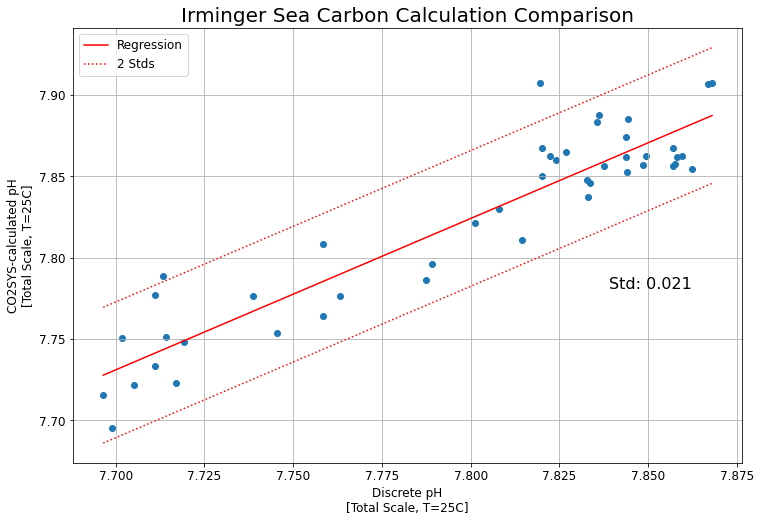

In [27]:
plt.rcParams["font.size"] = 12

# Look at how closely the pH measurements match eachother
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
ax.scatter(PHmeas, PHcalc)
ax.plot(PHmeas, PHpred, c='r', label='Regression')

#ax.fill_between(PHmeas, PHpred-1.96*PHstd, PHpred+1.96*PHstd, color="tab:red")
ax.plot(PHmeas, PHpred-1.96*PHstd, ':', c='r', label='2 Stds')
ax.plot(PHmeas, PHpred+1.96*PHstd, ':', c='r')
ax.set_xlabel('Discrete pH\n[Total Scale, T=25C]', fontsize=12)
ax.set_ylabel('CO2SYS-calculated pH\n[Total Scale, T=25C]', fontsize=12)
ax.text(0.8,0.4,f'Std: {PHstd.round(3)}', fontsize='16', transform=ax.transAxes)
ax.legend(fontsize=12)
ax.set_title("Irminger Sea Carbon Calculation Comparison", fontsize="20")
ax.grid()

##### Calculate the pCO2
Add the derived pCO2 and pH to the bottle data

In [28]:
irminger_sea["Calculated pCO2 [uatm]"] = CO2dict["pCO2_out"]
irminger_sea["Calculated pH"] = CO2dict["pH"]

#### Pioneer

In [29]:
# Get the key parameters
DIC = pioneer["Discrete DIC [umol/kg]"]
TA = pioneer["Discrete Alkalinity [umol/kg]"]
PH = pioneer["Discrete pH [Total scale]"].apply(lambda x: float(x))
SAL = pioneer["Discrete Salinity [psu]"]

# Set the input hydrographic parameters at which the DIC/TA/pH lab measurements were performed
TEMP_IN = 25
PRES_IN = 0

# Get the hydrographic parameters at which the samples were taken
TEMP_OUT = pioneer[["CTD Temperature 1 [deg C]","CTD Temperature 1 [deg C]"]].mean(axis=1, skipna=True)
PRES_OUT = pioneer["CTD Pressure [db]"]

# Nutrient inputs = need to fill NaNs with zeros otherwise will return NaNs
SIO4 = pioneer["Discrete Silicate [uM]"].fillna(value=0)
PO4 = pioneer["Discrete Phosphate [uM]"].fillna(value=0)
NH4 = pioneer["Discrete Ammonium [uM]"].fillna(value=0)

In [30]:
CO2dict = pyco2.CO2SYS_nd(TA, DIC, 1, 2, SAL, total_ammonia=NH4, total_phosphate=PO4, total_silicate=SIO4, 
                          temperature_out=TEMP_OUT, pressure_out=PRES_OUT)

In [31]:
# Get the pH data calculated from the DIC and TA
PHout = CO2dict["pH"]

In [32]:
# Next, check the pH results to see how the calculated pH compares with the measured pH
df = pd.DataFrame(data=[PH.values, PHout], index=["Measured", "CO2sys"]).T.dropna()
df = df[df["CO2sys"] > 7]
df = df.sort_values(by="Measured")
PHmeas = df["Measured"].values.reshape(-1,1)
PHcalc = df["CO2sys"].values.reshape(-1,1)

In [33]:
# Use sklearn linear regression model to determine the accuracy 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Fit a linear regression to the measured vs calculated pH values
regression = LinearRegression()
regression.fit(PHmeas, PHcalc)

# Get the regression values
PHpred = regression.predict(PHmeas)
PHmse = mean_squared_error(PHpred, PHcalc)
PHstd = np.sqrt(PHmse)

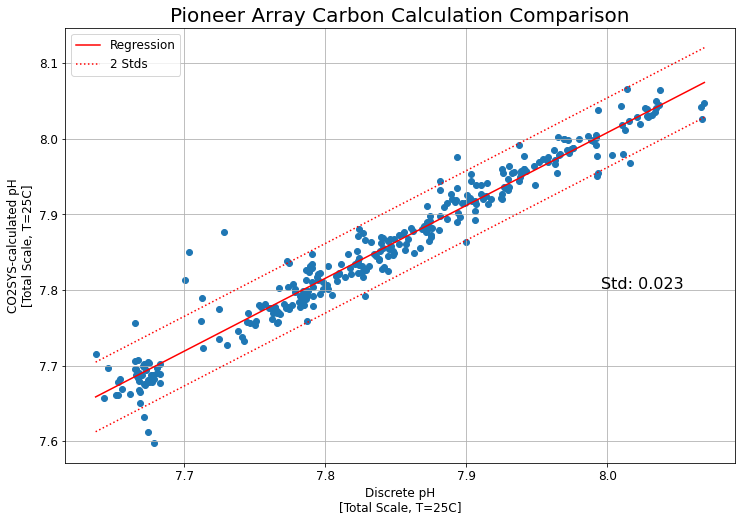

In [34]:
plt.rcParams["font.size"] = 12

# Look at how closely the pH measurements match eachother
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
ax.scatter(PHmeas, PHcalc)
ax.plot(PHmeas, PHpred, c='r', label='Regression')

#ax.fill_between(PHmeas, PHpred-1.96*PHstd, PHpred+1.96*PHstd, color="tab:red")
ax.plot(PHmeas, PHpred-1.96*PHstd, ':', c='r', label='2 Stds')
ax.plot(PHmeas, PHpred+1.96*PHstd, ':', c='r')
ax.set_xlabel('Discrete pH\n[Total Scale, T=25C]', fontsize=12)
ax.set_ylabel('CO2SYS-calculated pH\n[Total Scale, T=25C]', fontsize=12)
ax.text(0.8,0.4,f'Std: {PHstd.round(3)}', fontsize='16', transform=ax.transAxes)
ax.legend(fontsize=12)
ax.set_title("Pioneer Array Carbon Calculation Comparison", fontsize="20")
ax.grid()

##### Calculate the pCO2
Add the derived pCO2 and pH to the bottle data

In [35]:
pioneer["Calculated pCO2 [uatm]"] = CO2dict["pCO2_out"]
pioneer["Calculated pH"] = CO2dict["pH"]

## PCO2A

First, we examine the **```PCO2A```** dataset from the Irminger Surface Mooring Buoy. The **```PCO2A```** samples both the air and the surface water pCO2 concentrations. 

In [36]:
sys.path.append("../../")
from OS2022.OS2022 import plotting

In [37]:
# Get the dataset
pco2a = xr.open_dataset("../data/CP04OSSM_SBD12_04_PCO2AA000.nc")
pco2a

<xarray.Dataset>
Dimensions:                               (time: 351051)
Coordinates:
  * time                                  (time) datetime64[ns] 2015-05-10T01...
Data variables:
    humidity                              (time) float32 ...
    measured_water_co2                    (time) float32 ...
    irga_source_temperature               (time) float32 ...
    date_time_string                      (time) object ...
    dcl_controller_timestamp              (time) object ...
    current_a2d                           (time) float64 ...
    gas_stream_pressure                   (time) float32 ...
    internal_timestamp                    (time) datetime64[ns] ...
    deployment                            (time) int32 ...
    humidity_temperature                  (time) float32 ...
    irga_detector_temperature             (time) float32 ...
    zero_a2d                              (time) float64 ...
    avg_irga_temperature                  (time) float32 ...
    supply_voltage                        (time) float32 ...
    partial_pressure_co2_ssw              (time) float64 ...
    partial_pressure_co2_atm              (time) float64 ...
    met_salsurf                           (time) float64 ...
    sea_surface_temperature               (time) float64 ...
    met_wind10m                           (time) float64 ...
    pco2_co2flux                          (time) float64 ...
    shortwave_irradiance                  (time) float64 ...
    barometric_pressure                   (time) float64 ...
    precipitation                         (time) float64 ...
    relative_humidity                     (time) float64 ...
    air_temperature                       (time) float64 ...
    met_relwind_speed                     (time) float64 ...
    longwave_irradiance                   (time) float64 ...
    measured_water_co2_qc_executed        (time) float32 ...
    measured_water_co2_qc_results         (time) float32 ...
    partial_pressure_co2_ssw_qc_executed  (time) float32 ...
    partial_pressure_co2_ssw_qc_results   (time) float32 ...
    pco2_co2flux_qc_executed              (time) float32 ...
    pco2_co2flux_qc_results               (time) float32 ...
Attributes:
    node:                               SBD12
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             pco2a_a_dcl_instrument_water_recovered
    featureType:                        timeSeries
    creator_email:                      
    publisher_name:                     Ocean Observatories Initiative
    date_modified:                      2021-03-12T23:24:05.155579
    keywords:                           
    cdm_data_type:                      Station
    references:                         More information can be found at http...
    Metadata_Conventions:               Unidata Dataset Discovery v1.0
    date_created:                       2021-03-12T23:24:05.155573
    id:                                 CP04OSSM-SBD12-04-PCO2AA000-recovered...
    requestUUID:                        b876f15d-eb5d-4f63-b47a-0238ccb69688
    contributor_role:                   
    summary:                            Dataset Generated by Stream Engine fr...
    keywords_vocabulary:                
    institution:                        Ocean Observatories Initiative
    naming_authority:                   org.oceanobservatories
    infoUrl:                            http://oceanobservatories.org/
    license:                            
    contributor_name:                   
    uuid:                               b876f15d-eb5d-4f63-b47a-0238ccb69688
    creator_name:                       Ocean Observatories Initiative
    title:                              Data produced by Stream Engine versio...
    sensor:                             

(200.0, 500.0)

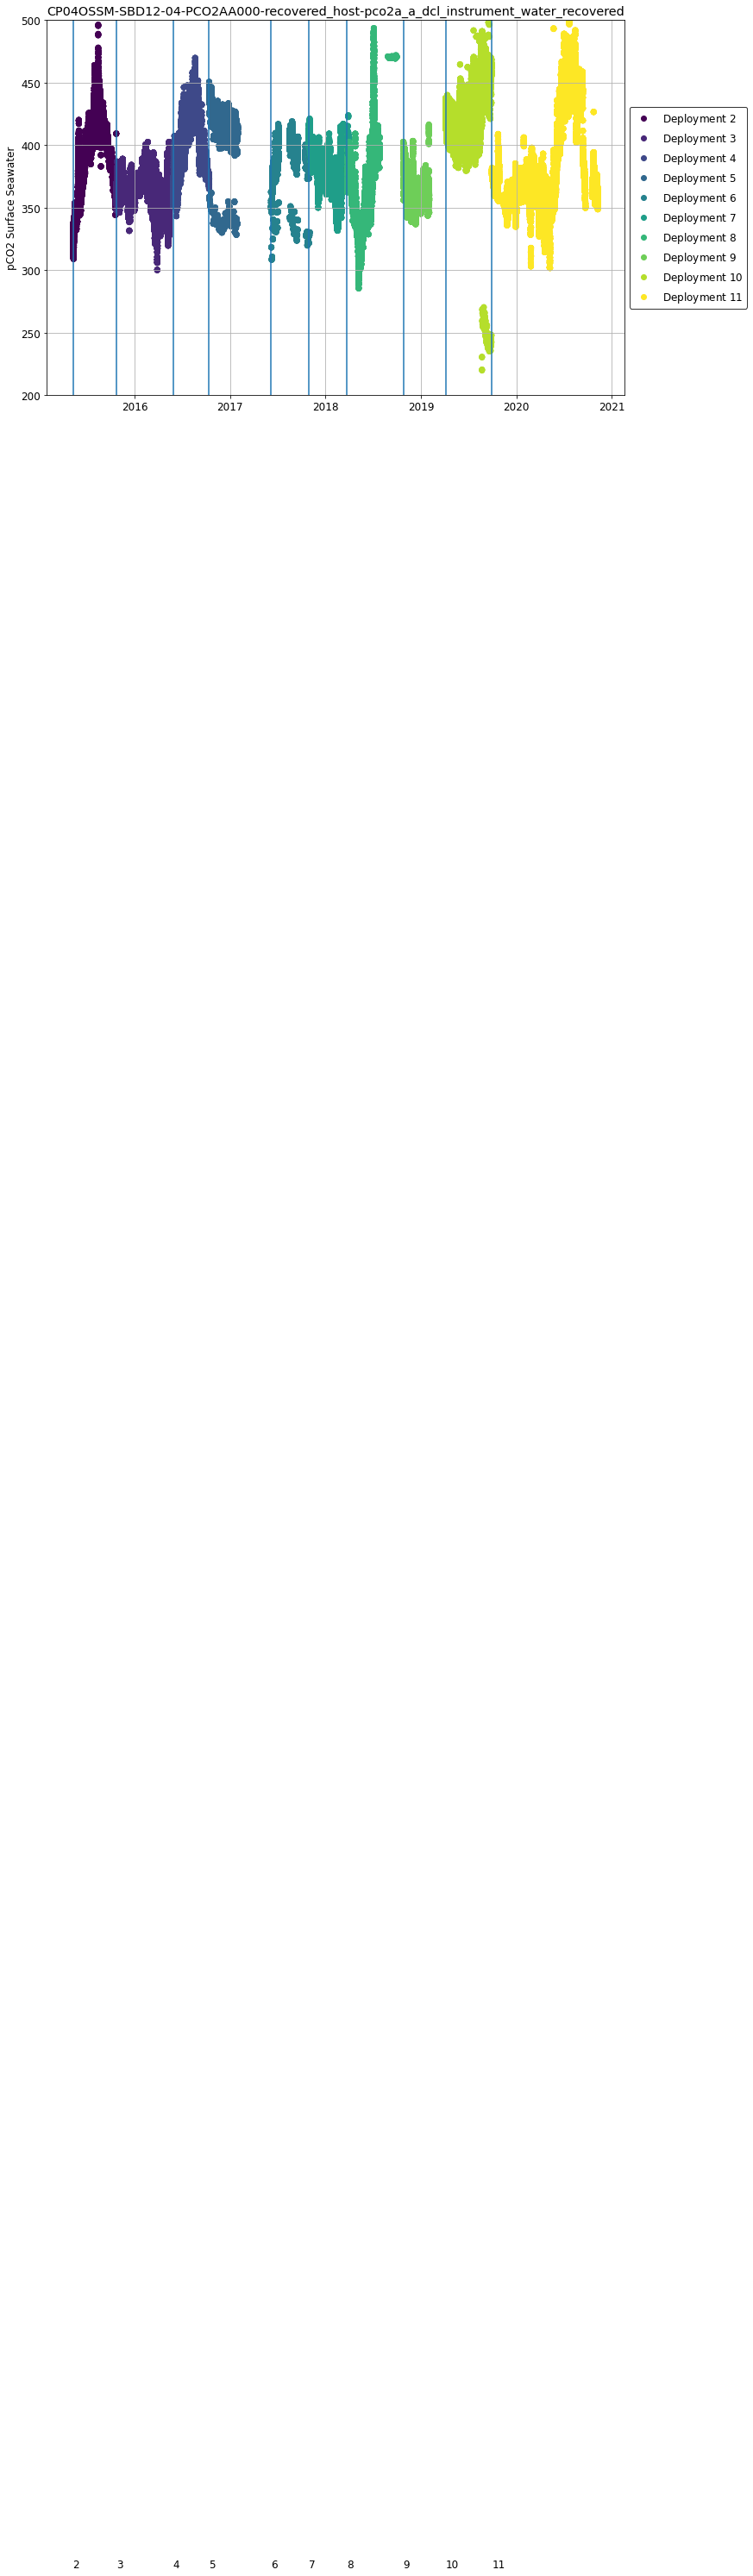

In [39]:
# Plot the data as a function of deployments
fig, ax = plotting.plot_data_variable(pco2a, "partial_pressure_co2_ssw")
ax.set_ylim((200, 500))

### Annotations
Next, add in the annotations to the dataset and filter out the data identified as bad

In [ ]:
annotations = OOINet.get_annotations("CP04OSSM-SBD12-04-PCO2AA000")
annotations

From the plot of the PCO2A, we can see that the instrument failed before recovery each time that it was deployed. Next, we want to add the annotation information to the OOI data

#### Add Annotation Information to dataset

In [ ]:
pco2a = OOINet.add_annotation_qc_flag(pco2a, annotations)
pco2a

In [ ]:
np.unique(pco2a.rollup_annotations_qc_results)

Plot the annotation data

In [ ]:
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
#ax.plot(pco2a.time, pco2a.partial_pressure_co2_ssw, marker=".", linestyle="", color="tab:blue")
# Plot the data as a function of deployments
fig, ax = plotting.plot_data_variable(pco2a, "partial_pressure_co2_ssw")
ax.plot(pco2a.time.where(pco2a.rollup_annotations_qc_results == 9, drop=True),
        pco2a.partial_pressure_co2_ssw.where(pco2a.rollup_annotations_qc_results == 9, drop=True),
        marker="o", linestyle="", color="tab:red")
ax.plot(pco2a.time.where(pco2a.rollup_annotations_qc_results == 3, drop=True),
        pco2a.partial_pressure_co2_ssw.where(pco2a.rollup_annotations_qc_results == 3, drop=True),
        marker="o", linestyle="", color="tab:orange")
ax.set_xlabel("time")
ax.set_ylabel(pco2a.partial_pressure_co2_ssw.attrs["long_name"])
ax.set_ylim((200, 500))
ax.grid()

#### Filter Annotations
Finally, remove the manually-identified bad data from the dataset

In [ ]:
pco2a = pco2a.where(pco2a.rollup_annotations_qc_results != 9, drop=True)
pco2a

In [ ]:
fig, ax = plotting.plot_data_variable(pco2a, "partial_pressure_co2_ssw")
ax.set_ylim((200, 500))

In [ ]:
pco2a.lat, pco2a.lon

### Identify discrete samples
Next, identify the discrete water samples associated with the Irminger Surface Buoy PCO2A. The surface samples should be less than 

In [42]:
!pip install haversine

  Using cached haversine-2.5.1-py2.py3-none-any.whl (6.1 kB)


In [41]:
import haversine as hs

ModuleNotFoundError: No module named 'haversine'

In [ ]:
# For each
loc1 = (59.9337, -39.47378)
loc2 = (59.94358, -39.57372)

In [40]:
def findNearest(bottleData, buoyLoc, maxDist):
    """Find the bottle sample values within a maximum distance from the buoy
    
    Parameters
    ----------
    bottleData: (pd.DataFrame -> strings or floats)
        A tuple of (latitude, longitude) values in decimal degrees of the bottle sample location
    buoyLoc: (tuple -> floats)
        A tuple of (latitude, longitude) values in decimal degrees of the buoy location
    maxDist: (float)
        Maximum distance in km away for a sample location from the buoy location
    
    Returns
    -------
    mask: (boolean)
        Returns True or False boolean if sampleLoc < maxDist from buoyLoc
    """
    # Get the startLat/startLon as floats
    startLat = pioneer["Start Latitude [degrees]"].apply(lambda x: float(x))
    startLon = bottleData["Start Longitude [degrees]"].apply(lambda x: float(x))
    
    # Calculate the distance
    distance = []
    for lat, lon in zip(startLat, startLon):
        sampleLoc = (lat, lon)
        distance.append(hs.haversine(sampleLoc, buoyLoc))
    
    # Filter the results
    return [d <= maxDist for d in dist]

In [ ]:
def findSamples(bottleData, buoyLoc, maxDist, depthTol):
    
    """Find the bottle sample values within a maximum distance from the buoy
    
    Parameters
    ----------
    bottleData: (pd.DataFrame -> strings or floats)
        A tuple of (latitude, longitude) values in decimal degrees of the bottle sample location
    buoyLoc: (tuple -> floats)
        A tuple of (latitude, longitude) values in decimal degrees of the buoy location
    maxDist: (float)
        Maximum distance in km away for a sample location from the buoy location
    
    Returns
    -------
    mask: (boolean)
        Returns True or False boolean if sampleLoc < maxDist from buoyLoc

In [ ]:
pco2a

In [ ]:
distMask = findNearest(pioneer, (pco2a.lat, pco2a.lon), 0.5)
pioneer[distMask]

In [ ]:
[x for x in hs.Unit if x.value == distUnit]

In [ ]:
startLat = pioneer["Start Latitude [degrees]"].apply(lambda x: float(x))
startLon = pioneer["Start Longitude [degrees]"].apply(lambda x: float(x))
dist = []
buoyLoc = (pco2a.lat, pco2a.lon)
for lat, lon in zip(startLat, startLon):
    sampleLoc = (lat, lon)
    dist.append(hs.haversine(sampleLoc, buoyLoc))


In [ ]:
[d <= 0.5 for d in dist]

In [ ]:
pco2a.lon

In [ ]:
# Identify samples associated with the instrument using the "target asset"
mask = pioneer["Target Asset"].apply(lambda x: True if "ossm" in x.lower() else False)
ossm_bottle_data = pioneer[mask]

In [ ]:
# Identify samples from near the surface, which we'll take as <= 15 dbar of pressure
mask = ossm_bottle_data["CTD Pressure [db]"] <= 15
ossm_pco2a_bottle_data = ossm_bottle_data[mask]
ossm_pco2a_bottle_data

In [ ]:
ossm_pco2a_bottle_data["Calculated pCO2 [uatm]"]

In [ ]:
# Plot the bottle data on top of the pco2a data
fig, ax = plotting.plot_data_variable(pco2a, "partial_pressure_co2_ssw")

ax.plot(ossm_pco2a_bottle_data["CTD Bottle Closure Time [UTC]"], ossm_pco2a_bottle_data["Calculated pCO2 [uatm]"],
        marker="o", color="tab:red", linestyle="", markersize=12)
ax.set_ylim((200, 500))

From the above plot of the discrete bottle samples against the PCO2A, we can select a couple of deployments for a closer analysis of the pCO2 calculated from the DIC/TA relationship and the measured seawater pCO2. We'll choose Deployments 3 and 7 to look at more closely.

In [ ]:
pco2a_deployment_3 = pco2a.where(pco2a.deployment == 3, drop=True)

Plot deployment 3 more closely

In [ ]:
fig, ax = plotting.plot_data_variable(pco2a_deployment_3, "partial_pressure_co2_ssw", add_deployments=False)
xlim = ax.get_xlim()

# Calculate the noise level
std = pco2a_deployment_3.partial_pressure_co2_ssw.diff(dim="time").std().values

ax.fill_between(pco2a_deployment_3.time,
                pco2a_deployment_3.partial_pressure_co2_ssw-2*std,
                pco2a_deployment_3.partial_pressure_co2_ssw+2*std,
                color="tab:blue")
ax.plot(ossm_pco2a_bottle_data["Start Time [UTC]"], ossm_pco2a_bottle_data["Calculated pCO2 [uatm]"], 
        color="tab:red", marker="*", linestyle="", markersize=12)
ax.set_xlim(xlim)

In [ ]:
# Write a function which takes in a time series and bottle values and plot the data comparisons

In [ ]:
deployments = np.unique(pco2a.deployment)
deployments

In [ ]:
results = pd.DataFrame()
for deployment in deployments:
    # First, select the relevant deployment data
    deployment_data = pco2a.where(pco2a.deployment == deployment, drop=True)
    
    # Get the refdes
    refdes = "-".join(pco2a.attrs["id"].split("-")[0:4])
    
    # Next, get the first and last timestamps of the pco2a data
    deployDT, recoverDT = deployment_data.time.min().values, deployment_data.time.max().values
    
    # Calculate the mean and std deviation for the first day of data from the instrument
    deploy_avg = deployment_data.partial_pressure_co2_ssw.where(deployment_data.time <= pd.to_datetime(deployDT + pd.Timedelta("1D"))).mean()
    deploy_std = deployment_data.partial_pressure_co2_ssw.where(deployment_data.time <= pd.to_datetime(deployDT + pd.Timedelta("1D"))).std()

    # Calculate the mean and std devation for the last day of the data from the instrument
    recover_avg = deployment_data.partial_pressure_co2_ssw.where(deployment_data.time >= pd.to_datetime(recoverDT - pd.Timedelta("1D"))).mean()
    recover_std = deployment_data.partial_pressure_co2_ssw.where(deployment_data.time >= pd.to_datetime(recoverDT - pd.Timedelta("1D"))).std()

    # Now, filter for the nearest bottle data based on start and stop times
    deploy_bottles = ossm_pco2a_bottle_data[
        (ossm_pco2a_bottle_data["Start Time [UTC]"] >= pd.to_datetime(deployDT - pd.Timedelta("1D"), utc=True)) &
        (ossm_pco2a_bottle_data["Start Time [UTC]"] <= pd.to_datetime(deployDT + pd.Timedelta("1D"), utc=True))]
    recover_bottles = ossm_pco2a_bottle_data[
        (ossm_pco2a_bottle_data["Start Time [UTC]"] >= pd.to_datetime(recoverDT - pd.Timedelta("1D"), utc=True)) &
        (ossm_pco2a_bottle_data["Start Time [UTC]"] <= pd.to_datetime(recoverDT + pd.Timedelta("1D"), utc=True))]
    
    # Whittle down the Deployment Data to the most relevant values
    columns=["CTD Pressure [db]", "CTD Absolute Salinity [g/kg]", "CTD Conservative Temperature", "Calculated pCO2 [uatm]"]
    
    
    # Okay, now calculate the comparison between the bottle and
    results = results.append(deploy_bottles)
    

In [ ]:
deployDT, recoverDT = pco2a_deployment_3.time.min().values, pco2a_deployment_3.time.max().values
deployDT, recoverDT

In [ ]:
refdes = "-".join(pco2a.attrs["id"].split("-")[0:4])
refdes

In [ ]:
pd.to_datetime(deployDT - pd.Timedelta("1D"), utc=True)

In [ ]:
deploy_bottles = ossm_pco2a_bottle_data[
    (ossm_pco2a_bottle_data["Start Time [UTC]"] >= pd.to_datetime(deployDT - pd.Timedelta("1D"), utc=True)) &
    (ossm_pco2a_bottle_data["Start Time [UTC]"] <= pd.to_datetime(deployDT + pd.Timedelta("1D"), utc=True))]

recover_bottles = ossm_pco2a_bottle_data[
    (ossm_pco2a_bottle_data["Start Time [UTC]"] >= pd.to_datetime(recoverDT - pd.Timedelta("1D"), utc=True)) &
    (ossm_pco2a_bottle_data["Start Time [UTC]"] <= pd.to_datetime(recoverDT + pd.Timedelta("1D"), utc=True))]

In [ ]:
deploy_bottles[["CTD Pressure [db]", "CTD Absolute Salinity [g/kg]", "CTD Conservative Temperature", "Calculated pCO2 [uatm]"]]

In [ ]:
# Calculate the comparison values
deploy_avg = pco2a_deployment_3.partial_pressure_co2_ssw.where(pco2a_deployment_3.time <= pd.to_datetime(deployDT + pd.Timedelta("1D"))).mean()
deploy_std = pco2a_deployment_3.partial_pressure_co2_ssw.where(pco2a_deployment_3.time <= pd.to_datetime(deployDT + pd.Timedelta("1D"))).std()
deploy_avg, deploy_std

In [ ]:
deploy_bottles["Calculated pCO2 [uatm]"]

In [ ]:
# Calculate the comparison values
recover_avg = pco2a_deployment_3.partial_pressure_co2_ssw.where(pco2a_deployment_3.time >= pd.to_datetime(recoverDT - pd.Timedelta("1D"))).mean()
recover_std = pco2a_deployment_3.partial_pressure_co2_ssw.where(pco2a_deployment_3.time >= pd.to_datetime(recoverDT - pd.Timedelta("1D"))).std()
recover_avg, recover_std

In [ ]:
recover_bottles["Calculated pCO2 [uatm]"]

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary ")

In [ ]:
adfuller_test(pco2a_deployment_3["partial_pressure_co2_ssw"])

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2,1,1)
fig = plot_acf(pco2a_deployment_3.partial_pressure_co2_ssw.diff(dim="time"), lags=40, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = plot_pacf(pco2a_deployment_3.partial_pressure_co2_ssw.diff(dim="time"), lags=40, ax=ax2)

We'll calculate the noise term using a first-difference estimate to get the standard deviation of the data

---
## Instrument Datasets

### Irminger Array
* GI01SUMO: Apex Surface Mooring
    * SBD12: Surface Buoy
        * PCO2AA: pCO2 Air-Sea (refdes = GI01SUMO-SBD12-04-PCO2AA000)
        * METBKA: Bulk Meteorology Instrument Package (refdes = GI01SUMO-SBD12-06-METBKA000)
    * RID16: Near-Surface Instrument Frame
        * PCO2WB: pCO2 Water (refdes = GI01SUMO-RID16-05-PCO2WB000)
        * CTDBPF: CTD (refdes = GI01SUMO-RID16-03-CTDBPF000)
    * RII11: Mooring Riser
        * PCO2WC: pCO2 Water (40 meters) (refdes = GI01SUMO-RII11-02-PCO2WC051)
        * CTDMOQ: CTD (40 meters) (refdes = GI01SUMO-RII11-02-CTDMOQ031)
        * PCO2WC: pCO2 Water (80 meters) (refdes = GI01SUMO-RII11-02-PCO2WC052)
        * CTDBPP: CTD (80 meters) (refdes = GI01SUMO-RII11-02-CTDBPP032)
        * PCO2WC: pCO2 Water (130 meters) (refdes = GI01SUMO-RII11-02-PCO2WC053)
        * CTDBPP: CTD (130 meters) (refdes = GI01SUMO-RII11-02-CTDBPP033)
        * PHSENE: Seawater pH (20 meters) (refdes = GI01SUMO-RII11-02-PHSENE041)
        * CTDMOQ: CTD (20 meters) (refdes = GI01SUMO-RII11-02-CTDMOQ011)
        * PHSENE: Seawater pH (100 meters) (refdes = GI01SUMO-RII11-02-PHSENE042)
        * CTDMOQ: CTD (100 meters) (refdes = GI01SUMO-RII11-02-CTDMOQ013)
* GI03FLMA: Flanking Subsurface Mooring A
    * RIS01: Mooring Riser
        * PHSENF: Seawater pH (refdes = GI03FLMA-RIS01-04-PHSENF000)
        * CTDMOG: CTD (30 meters) (refdes = GI03FLMA-RIM01-02-CTDMOG040)
* GI03FLMB: Flanking Subsurface Mooring B
    * RIS01: Mooring Riser
        * PHSENF: Seawater pH (refdes = GI03FLMB-RIS01-04-PHSENF000)
        * CTDMOG: CTD (30 meters) (refdes = GI03FLMB-RIM01-02-CTDMOG060)
        
---
## Surface Mooring